<a href="https://colab.research.google.com/github/faizankshaikh/HomMul/blob/main/experiments/trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q black gymnasium pettingzoo tianshou
# !git clone https://github.com/faizankshaikh/HomMul.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.1/816.1 kB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 22.2 MB/s eta 0:00:00
Cloning into 'HomMul'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 54 (delta 18), reused 31 (delta 7), pack-reused 0
Unpacking objects: 100% (54/54), 503.26 KiB | 9.15 MiB/s, done.


In [1]:
%cd HomMul/

/content/HomMul


In [2]:
%load_ext tensorboard

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hommul.envs.hommul_v0 import HomMul

from torch.optim import Adam

from tianshou.data import Batch
from tianshou.utils.net.common import Net
from tianshou.utils import TensorboardLogger
from tianshou.trainer import offpolicy_trainer
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv, PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager

from pettingzoo.utils import parallel_to_aec

from torch.utils.tensorboard import SummaryWriter

In [3]:
env = HomMul()
original_env = HomMul(render_mode="human")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# example of gameplay
episodes = 1

for episode in range(episodes):
    print(f"Episode #{episode+1}")
    print("=" * 10)
    obs = original_env.reset()
    print()

    while original_env.agents:
        acts = {
            "player1": np.random.choice([0, 1]),
            "player2": np.random.choice([0, 1])
        }
        print(f"--Action taken by player 1: {original_env.action_dict[acts['player1']]}")
        print(f"--Action taken by player 2: {original_env.action_dict[acts['player2']]}")
        print()

        obs, rews, terms, truncs, infos = original_env.step(acts)
        print()

Episode #1
--Days left: 2
--Current life of agent 1: 2
--Current life of agent 2: 2
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2

--Action taken by player 1: wait
--Action taken by player 2: wait

--Days left: 1
--Current life of agent 1: 1
--Current life of agent 2: 1
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4
--Previous action of agent 1: wait
--Previous action of agent 2: wait

--Action taken by player 1: play
--Action taken by player 2: wait

--Days left: 0
--Current life of agent 1: 0
--Current life of agent 2: 0
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4
--Previous action of agent 1: play
--Previous action of agent 2: wait



death rate of player2: 0.329
ratio of death rate of player2 with respect to player1: 0.892


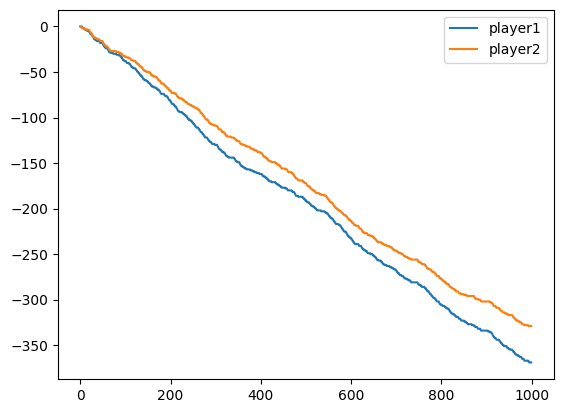

In [5]:
# both always play
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.449
ratio of death rate of player2 with respect to player1: 0.720


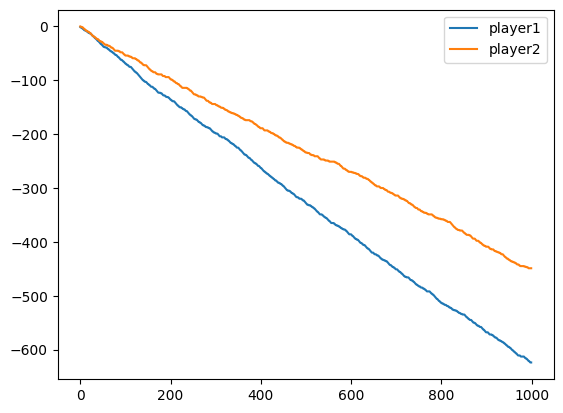

In [6]:
# both always wait
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.563
ratio of death rate of player2 with respect to player1: 0.860


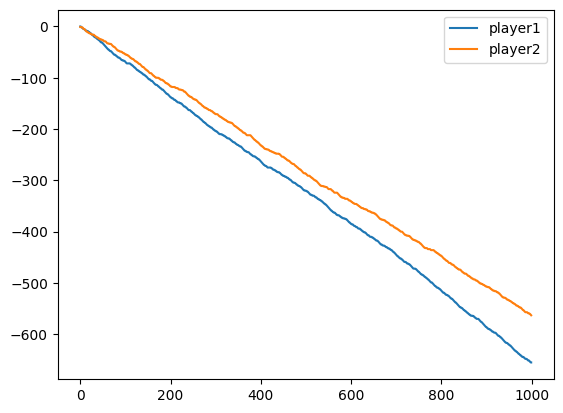

In [7]:
# player1 waits, player2 plays
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.426
ratio of death rate of player2 with respect to player1: 0.690


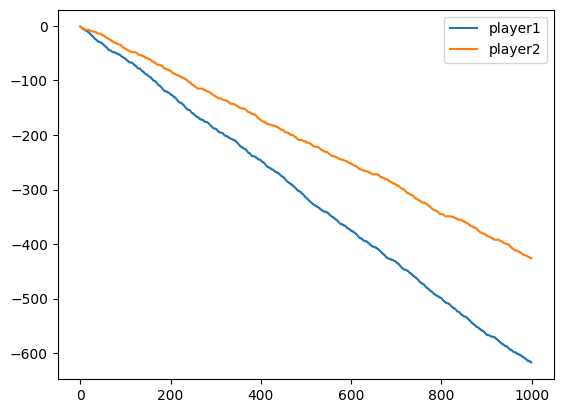

In [8]:
# player1 plays, player2 waits
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.391
ratio of death rate of player2 with respect to player1: 0.784


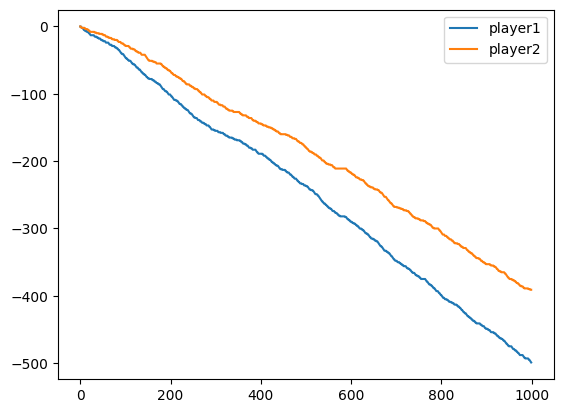

In [9]:
# Always play vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.516
ratio of death rate of player2 with respect to player1: 0.805


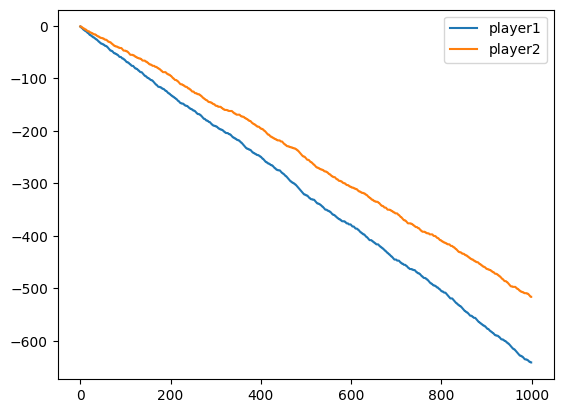

In [10]:
# Always wait vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.214
ratio of death rate of player2 with respect to player1: 0.380


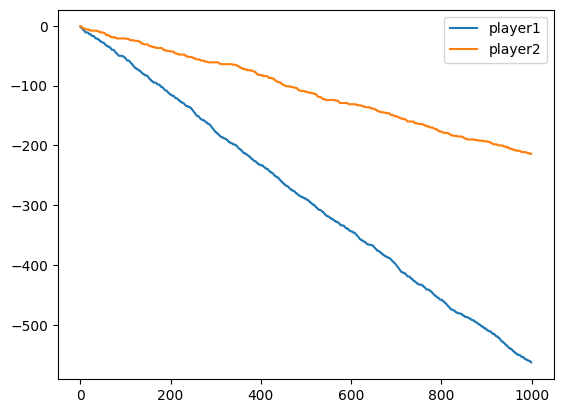

In [11]:
# Always play vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.314
ratio of death rate of player2 with respect to player1: 0.486


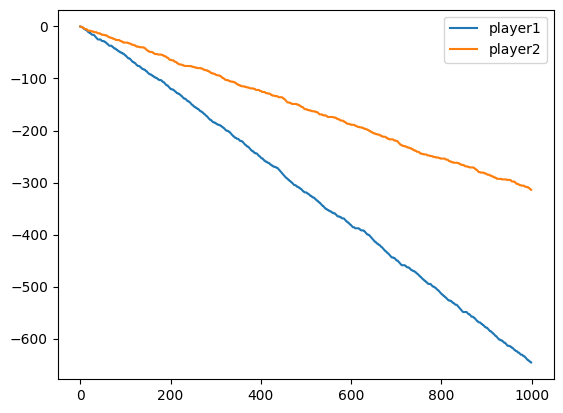

In [12]:
# Always wait vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [13]:
def optimal(obs):
    df = pd.read_csv("models/optimal_policy.csv")
    return df.loc[
        (df["days_left"] == obs["player1"]["observation"][0][0]) &
        (df["player1_life_points"] == obs["player1"]["observation"][0][1]) &
        (df["player2_life_points"] == obs["player1"]["observation"][0][2]) &
        (df["player1_prob_payoff"] == obs["player1"]["observation"][0][3])
    ]["action"].values[0] - 1

death rate of player2: 0.293
ratio of death rate of player2 with respect to player1: 0.539


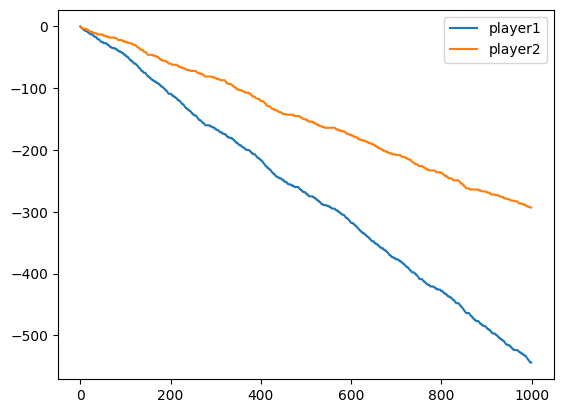

In [14]:
# hail mary vs optimal
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0,
            "player2": optimal(obs)
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.346
ratio of death rate of player2 with respect to player1: 0.546


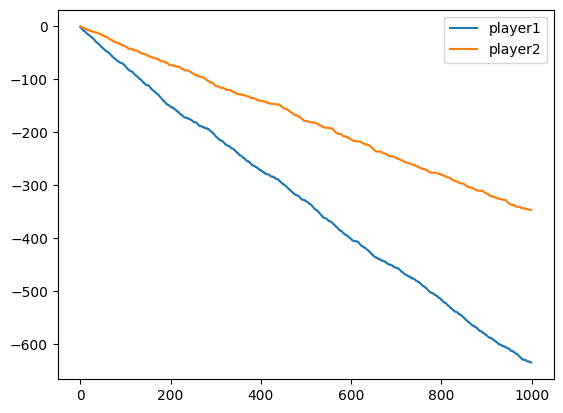

In [15]:
# Always wait vs optimal
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": optimal(obs)
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.197
ratio of death rate of player2 with respect to player1: 0.416


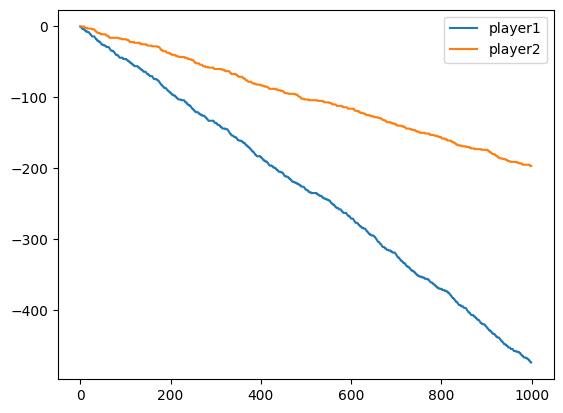

In [16]:
# Always play vs optimal
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": optimal(obs)
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [14]:
## agent that always plays
class AlwaysPlay(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)
    
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 1] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that always waits
class AlwaysWait(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that waits for low health to play
class HailMary(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        for i in range(mask.shape[0]):
            if obs[i, :, 1] <= 1:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## random agent
class RandomAgent(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, np.random.choice([0, 1])] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

In [15]:
# Step 2: Wrap the environment for Tianshou interfacing
def _get_env():
    env = HomMul()
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

# seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

env = HomMul()
agents =  env.agents[:]

# Step 3: Define policies for each agent
## learning agent
def _get_agent(pretrained=False):
    vec_env = _get_env()
    net = Net(
        state_shape=vec_env.observation_space.shape,
        action_shape=vec_env.action_space.n,
        hidden_sizes=[128, 128],
        device="cuda",
    ).to("cuda")
    optim = Adam(net.parameters(), lr=1e-4)
    model = DQNPolicy(
        model=net,
        optim=optim,
        discount_factor=0.9,
        estimation_step=3,
        target_update_freq=50,
    )

    # if pretrained:
    #     model_save_path = os.path.join("models", "vs_hail_mary.pth")
    #     model.load_state_dict(torch.load(model_save_path))
    return model

agent_learn1 = _get_agent()
agent_learn2 = _get_agent()

policy = MultiAgentPolicyManager([AlwaysPlay(), agent_learn2],  _get_env())

train_envs = DummyVectorEnv([_get_env for _ in range(5)])
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
train_envs.seed(seed)
test_envs.seed(seed)

# Step 4: Collector setup
train_collector = Collector(
    policy,
    train_envs,
    VectorReplayBuffer(20_000, len(train_envs)),
    exploration_noise=True,
)
test_collector = Collector(policy, test_envs, exploration_noise=True)

train_collector.collect(n_step=50)

def save_best_fn(policy):
    model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    os.makedirs(os.path.join("log", "hommul", "dqn"), exist_ok=True)
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        torch.save(policy.policies[agents[0]].state_dict(), model_save_path1)
    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        torch.save(policy.policies[agents[1]].state_dict(), model_save_path2)

def stop_fn(mean_rewards):
    return mean_rewards >= 10

def train_fn(epoch, env_step):
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        policy.policies[agents[0]].set_eps(0.1)

    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        policy.policies[agents[1]].set_eps(0.1)

def test_fn(epoch, env_step):
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        policy.policies[agents[0]].set_eps(0.05)

    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        policy.policies[agents[1]].set_eps(0.05)

def reward_metric(rews):
    return rews[:, 1]

In [16]:
# clear logs and setup TBoard
!rm -rf /content/HomMul/log

log_path = os.path.join("log", "hommul", "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Step 5: Run trainer
result = offpolicy_trainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=100,
    step_per_epoch=1000,
    step_per_collect=50,
    episode_per_test=100,
    batch_size=64,
    train_fn=train_fn,
    test_fn=test_fn,
    stop_fn=stop_fn,
    save_best_fn=save_best_fn,
    update_per_step=0.1,
    test_in_train=False,
    reward_metric=reward_metric,
    logger=logger
)
result

Epoch #1: 1001it [00:02, 482.30it/s, env_step=1000, len=2, n/ep=17, n/st=50, player2/loss=0.298, rew=-0.41]                          


Epoch #1: test_reward: -0.280000 ± 0.448999, best_reward: -0.280000 ± 0.448999 in #1


Epoch #2: 1001it [00:00, 1186.29it/s, env_step=2000, len=3, n/ep=18, n/st=50, player2/loss=0.303, rew=-0.33]                          


Epoch #2: test_reward: -0.310000 ± 0.462493, best_reward: -0.280000 ± 0.448999 in #1


Epoch #3: 1001it [00:00, 1169.41it/s, env_step=3000, len=3, n/ep=16, n/st=50, player2/loss=0.368, rew=-0.31]                          


Epoch #3: test_reward: -0.350000 ± 0.476970, best_reward: -0.280000 ± 0.448999 in #1


Epoch #4: 1001it [00:00, 1173.30it/s, env_step=4000, len=3, n/ep=18, n/st=50, player2/loss=0.435, rew=-0.33]                          


Epoch #4: test_reward: -0.370000 ± 0.482804, best_reward: -0.280000 ± 0.448999 in #1


Epoch #5: 1001it [00:00, 1108.09it/s, env_step=5000, len=2, n/ep=17, n/st=50, player2/loss=0.505, rew=-0.18]                          


Epoch #5: test_reward: -0.290000 ± 0.453762, best_reward: -0.280000 ± 0.448999 in #1


Epoch #6: 1001it [00:01, 869.73it/s, env_step=6000, len=2, n/ep=17, n/st=50, player2/loss=0.638, rew=-0.53]                          


Epoch #6: test_reward: -0.310000 ± 0.462493, best_reward: -0.280000 ± 0.448999 in #1


Epoch #7: 1001it [00:01, 940.37it/s, env_step=7000, len=3, n/ep=18, n/st=50, player2/loss=0.765, rew=-0.50]                          


Epoch #7: test_reward: -0.300000 ± 0.458258, best_reward: -0.280000 ± 0.448999 in #1


Epoch #8: 1001it [00:00, 1194.52it/s, env_step=8000, len=3, n/ep=16, n/st=50, player2/loss=0.789, rew=-0.38]                          


Epoch #8: test_reward: -0.260000 ± 0.438634, best_reward: -0.260000 ± 0.438634 in #8


Epoch #9: 1001it [00:00, 1218.42it/s, env_step=9000, len=2, n/ep=17, n/st=50, player2/loss=0.925, rew=-0.29]                          


Epoch #9: test_reward: -0.380000 ± 0.485386, best_reward: -0.260000 ± 0.438634 in #8


Epoch #10: 1001it [00:00, 1198.93it/s, env_step=10000, len=2, n/ep=19, n/st=50, player2/loss=0.978, rew=-0.32]                          


Epoch #10: test_reward: -0.380000 ± 0.485386, best_reward: -0.260000 ± 0.438634 in #8


Epoch #11: 1001it [00:00, 1143.30it/s, env_step=11000, len=3, n/ep=16, n/st=50, player2/loss=1.119, rew=-0.56]                          


Epoch #11: test_reward: -0.370000 ± 0.482804, best_reward: -0.260000 ± 0.438634 in #8


Epoch #12: 1001it [00:00, 1213.07it/s, env_step=12000, len=2, n/ep=17, n/st=50, player2/loss=1.044, rew=-0.24]                          


Epoch #12: test_reward: -0.330000 ± 0.470213, best_reward: -0.260000 ± 0.438634 in #8


Epoch #13: 1001it [00:00, 1179.71it/s, env_step=13000, len=3, n/ep=16, n/st=50, player2/loss=1.215, rew=-0.19]                          


Epoch #13: test_reward: -0.380000 ± 0.485386, best_reward: -0.260000 ± 0.438634 in #8


Epoch #14: 1001it [00:00, 1218.93it/s, env_step=14000, len=2, n/ep=17, n/st=50, player2/loss=1.176, rew=-0.24]                          


Epoch #14: test_reward: -0.260000 ± 0.438634, best_reward: -0.260000 ± 0.438634 in #8


Epoch #15: 1001it [00:00, 1254.17it/s, env_step=15000, len=3, n/ep=14, n/st=50, player2/loss=1.263, rew=-0.43]                          


Epoch #15: test_reward: -0.340000 ± 0.473709, best_reward: -0.260000 ± 0.438634 in #8


Epoch #16: 1001it [00:00, 1153.16it/s, env_step=16000, len=3, n/ep=15, n/st=50, player2/loss=1.291, rew=-0.40]                          


Epoch #16: test_reward: -0.430000 ± 0.495076, best_reward: -0.260000 ± 0.438634 in #8


Epoch #17: 1001it [00:01, 982.60it/s, env_step=17000, len=2, n/ep=18, n/st=50, player2/loss=1.324, rew=-0.11]                          


Epoch #17: test_reward: -0.310000 ± 0.462493, best_reward: -0.260000 ± 0.438634 in #8


Epoch #18: 1001it [00:01, 892.86it/s, env_step=18000, len=2, n/ep=16, n/st=50, player2/loss=1.250, rew=-0.31]                          


Epoch #18: test_reward: -0.270000 ± 0.443959, best_reward: -0.260000 ± 0.438634 in #8


Epoch #19: 1001it [00:00, 1094.70it/s, env_step=19000, len=2, n/ep=17, n/st=50, player2/loss=1.361, rew=-0.24]                          


Epoch #19: test_reward: -0.340000 ± 0.473709, best_reward: -0.260000 ± 0.438634 in #8


Epoch #20: 1001it [00:00, 1221.75it/s, env_step=20000, len=3, n/ep=16, n/st=50, player2/loss=1.414, rew=-0.31]                          


Epoch #20: test_reward: -0.390000 ± 0.487750, best_reward: -0.260000 ± 0.438634 in #8


Epoch #21: 1001it [00:00, 1222.28it/s, env_step=21000, len=3, n/ep=17, n/st=50, player2/loss=1.505, rew=-0.35]                          


Epoch #21: test_reward: -0.380000 ± 0.485386, best_reward: -0.260000 ± 0.438634 in #8


Epoch #22: 1001it [00:01, 874.58it/s, env_step=22000, len=3, n/ep=16, n/st=50, player2/loss=1.658, rew=-0.31]                           


Epoch #22: test_reward: -0.380000 ± 0.485386, best_reward: -0.260000 ± 0.438634 in #8


Epoch #23: 1001it [00:00, 1217.27it/s, env_step=23000, len=3, n/ep=16, n/st=50, player2/loss=1.695, rew=-0.44]                          


Epoch #23: test_reward: -0.360000 ± 0.480000, best_reward: -0.260000 ± 0.438634 in #8


Epoch #24: 1001it [00:01, 584.22it/s, env_step=24000, len=3, n/ep=16, n/st=50, player2/loss=1.652, rew=-0.38]                          


Epoch #24: test_reward: -0.300000 ± 0.458258, best_reward: -0.260000 ± 0.438634 in #8


Epoch #25: 1001it [00:01, 723.75it/s, env_step=25000, len=2, n/ep=18, n/st=50, player2/loss=1.482, rew=-0.17]                          


Epoch #25: test_reward: -0.410000 ± 0.491833, best_reward: -0.260000 ± 0.438634 in #8


Epoch #26: 1001it [00:01, 770.72it/s, env_step=26000, len=3, n/ep=15, n/st=50, player2/loss=1.528, rew=-0.13]                          


Epoch #26: test_reward: -0.320000 ± 0.466476, best_reward: -0.260000 ± 0.438634 in #8


Epoch #27: 1001it [00:01, 938.04it/s, env_step=27000, len=2, n/ep=18, n/st=50, player2/loss=1.491, rew=-0.17]                          


Epoch #27: test_reward: -0.340000 ± 0.473709, best_reward: -0.260000 ± 0.438634 in #8


Epoch #28: 1001it [00:01, 970.39it/s, env_step=28000, len=3, n/ep=17, n/st=50, player2/loss=1.638, rew=-0.29]                           


Epoch #28: test_reward: -0.300000 ± 0.458258, best_reward: -0.260000 ± 0.438634 in #8


Epoch #29: 1001it [00:00, 1197.75it/s, env_step=29000, len=2, n/ep=16, n/st=50, player2/loss=1.562, rew=-0.31]                          


Epoch #29: test_reward: -0.270000 ± 0.443959, best_reward: -0.260000 ± 0.438634 in #8


Epoch #30: 1001it [00:00, 1212.57it/s, env_step=30000, len=2, n/ep=19, n/st=50, player2/loss=1.530, rew=-0.53]                          


Epoch #30: test_reward: -0.320000 ± 0.466476, best_reward: -0.260000 ± 0.438634 in #8


Epoch #31: 1001it [00:00, 1190.31it/s, env_step=31000, len=3, n/ep=15, n/st=50, player2/loss=1.573, rew=-0.47]                          


Epoch #31: test_reward: -0.340000 ± 0.473709, best_reward: -0.260000 ± 0.438634 in #8


Epoch #32: 1001it [00:00, 1192.36it/s, env_step=32000, len=2, n/ep=17, n/st=50, player2/loss=1.517, rew=-0.35]                          


Epoch #32: test_reward: -0.290000 ± 0.453762, best_reward: -0.260000 ± 0.438634 in #8


Epoch #33: 1001it [00:00, 1209.27it/s, env_step=33000, len=2, n/ep=18, n/st=50, player2/loss=1.475, rew=-0.17]                          


Epoch #33: test_reward: -0.370000 ± 0.482804, best_reward: -0.260000 ± 0.438634 in #8


Epoch #34: 1001it [00:00, 1197.50it/s, env_step=34000, len=3, n/ep=15, n/st=50, player2/loss=1.605, rew=-0.47]                          


Epoch #34: test_reward: -0.470000 ± 0.499099, best_reward: -0.260000 ± 0.438634 in #8


Epoch #35: 1001it [00:00, 1173.83it/s, env_step=35000, len=3, n/ep=15, n/st=50, player2/loss=1.652, rew=-0.40]                          


Epoch #35: test_reward: -0.330000 ± 0.470213, best_reward: -0.260000 ± 0.438634 in #8


Epoch #36: 1001it [00:01, 925.50it/s, env_step=36000, len=2, n/ep=17, n/st=50, player2/loss=1.540, rew=-0.29]                          


Epoch #36: test_reward: -0.270000 ± 0.443959, best_reward: -0.260000 ± 0.438634 in #8


Epoch #37: 1001it [00:01, 897.47it/s, env_step=37000, len=3, n/ep=17, n/st=50, player2/loss=1.706, rew=-0.18]                          


Epoch #37: test_reward: -0.410000 ± 0.491833, best_reward: -0.260000 ± 0.438634 in #8


Epoch #38: 1001it [00:01, 505.21it/s, env_step=38000, len=3, n/ep=16, n/st=50, player2/loss=1.661, rew=-0.62]                          


Epoch #38: test_reward: -0.320000 ± 0.466476, best_reward: -0.260000 ± 0.438634 in #8


Epoch #39: 1001it [00:01, 660.44it/s, env_step=39000, len=2, n/ep=18, n/st=50, player2/loss=1.602, rew=-0.28]                          


Epoch #39: test_reward: -0.390000 ± 0.487750, best_reward: -0.260000 ± 0.438634 in #8


Epoch #40: 1001it [00:01, 752.14it/s, env_step=40000, len=3, n/ep=17, n/st=50, player2/loss=1.588, rew=-0.35]                          


Epoch #40: test_reward: -0.340000 ± 0.473709, best_reward: -0.260000 ± 0.438634 in #8


Epoch #41: 1001it [00:00, 1151.84it/s, env_step=41000, len=2, n/ep=18, n/st=50, player2/loss=1.828, rew=-0.39]                          


Epoch #41: test_reward: -0.340000 ± 0.473709, best_reward: -0.260000 ± 0.438634 in #8


Epoch #42: 1001it [00:00, 1213.99it/s, env_step=42000, len=3, n/ep=15, n/st=50, player2/loss=1.644, rew=-0.07]                          


Epoch #42: test_reward: -0.400000 ± 0.489898, best_reward: -0.260000 ± 0.438634 in #8


Epoch #43: 1001it [00:01, 728.74it/s, env_step=43000, len=3, n/ep=18, n/st=50, player2/loss=1.669, rew=-0.28]                          


Epoch #43: test_reward: -0.300000 ± 0.458258, best_reward: -0.260000 ± 0.438634 in #8


Epoch #44: 1001it [00:01, 753.96it/s, env_step=44000, len=3, n/ep=14, n/st=50, player2/loss=1.676, rew=-0.43]                          


Epoch #44: test_reward: -0.330000 ± 0.470213, best_reward: -0.260000 ± 0.438634 in #8


Epoch #45: 1001it [00:00, 1133.94it/s, env_step=45000, len=3, n/ep=18, n/st=50, player2/loss=1.767, rew=-0.50]                          


Epoch #45: test_reward: -0.280000 ± 0.448999, best_reward: -0.260000 ± 0.438634 in #8


Epoch #46: 1001it [00:01, 919.69it/s, env_step=46000, len=3, n/ep=16, n/st=50, player2/loss=1.786, rew=-0.44]                          


Epoch #46: test_reward: -0.350000 ± 0.476970, best_reward: -0.260000 ± 0.438634 in #8


Epoch #47: 1001it [00:01, 888.40it/s, env_step=47000, len=3, n/ep=13, n/st=50, player2/loss=1.865, rew=-0.38]                          


Epoch #47: test_reward: -0.350000 ± 0.476970, best_reward: -0.260000 ± 0.438634 in #8


Epoch #48: 1001it [00:01, 973.42it/s, env_step=48000, len=3, n/ep=15, n/st=50, player2/loss=1.864, rew=-0.47]                           


Epoch #48: test_reward: -0.270000 ± 0.443959, best_reward: -0.260000 ± 0.438634 in #8


Epoch #49: 1001it [00:00, 1193.89it/s, env_step=49000, len=3, n/ep=17, n/st=50, player2/loss=1.687, rew=-0.41]                          


Epoch #49: test_reward: -0.330000 ± 0.470213, best_reward: -0.260000 ± 0.438634 in #8


Epoch #50: 1001it [00:00, 1223.31it/s, env_step=50000, len=2, n/ep=17, n/st=50, player2/loss=1.719, rew=-0.29]                          


Epoch #50: test_reward: -0.370000 ± 0.482804, best_reward: -0.260000 ± 0.438634 in #8


Epoch #51: 1001it [00:00, 1200.83it/s, env_step=51000, len=3, n/ep=15, n/st=50, player2/loss=1.747, rew=-0.47]                          


Epoch #51: test_reward: -0.330000 ± 0.470213, best_reward: -0.260000 ± 0.438634 in #8


Epoch #52: 1001it [00:00, 1223.94it/s, env_step=52000, len=3, n/ep=18, n/st=50, player2/loss=1.631, rew=-0.33]                          


Epoch #52: test_reward: -0.350000 ± 0.476970, best_reward: -0.260000 ± 0.438634 in #8


Epoch #53: 1001it [00:00, 1203.07it/s, env_step=53000, len=3, n/ep=18, n/st=50, player2/loss=1.794, rew=-0.22]                          


Epoch #53: test_reward: -0.300000 ± 0.458258, best_reward: -0.260000 ± 0.438634 in #8


Epoch #54: 1001it [00:00, 1198.39it/s, env_step=54000, len=2, n/ep=17, n/st=50, player2/loss=1.694, rew=-0.29]                          


Epoch #54: test_reward: -0.380000 ± 0.485386, best_reward: -0.260000 ± 0.438634 in #8


Epoch #55: 1001it [00:00, 1157.12it/s, env_step=55000, len=3, n/ep=15, n/st=50, player2/loss=1.706, rew=-0.40]                          


Epoch #55: test_reward: -0.340000 ± 0.473709, best_reward: -0.260000 ± 0.438634 in #8


Epoch #56: 1001it [00:00, 1175.13it/s, env_step=56000, len=2, n/ep=18, n/st=50, player2/loss=1.660, rew=-0.39]                          


Epoch #56: test_reward: -0.400000 ± 0.489898, best_reward: -0.260000 ± 0.438634 in #8


Epoch #57: 1001it [00:00, 1194.77it/s, env_step=57000, len=3, n/ep=16, n/st=50, player2/loss=1.702, rew=-0.44]                          


Epoch #57: test_reward: -0.290000 ± 0.453762, best_reward: -0.260000 ± 0.438634 in #8


Epoch #58: 1001it [00:01, 871.20it/s, env_step=58000, len=2, n/ep=16, n/st=50, player2/loss=1.628, rew=-0.19]                          


Epoch #58: test_reward: -0.460000 ± 0.498397, best_reward: -0.260000 ± 0.438634 in #8


Epoch #59: 1001it [00:01, 871.35it/s, env_step=59000, len=3, n/ep=16, n/st=50, player2/loss=1.615, rew=-0.25]                          


Epoch #59: test_reward: -0.320000 ± 0.466476, best_reward: -0.260000 ± 0.438634 in #8


Epoch #60: 1001it [00:00, 1141.26it/s, env_step=60000, len=2, n/ep=14, n/st=50, player2/loss=1.543, rew=-0.21]                          


Epoch #60: test_reward: -0.230000 ± 0.420833, best_reward: -0.230000 ± 0.420833 in #60


Epoch #61: 1001it [00:00, 1198.72it/s, env_step=61000, len=3, n/ep=16, n/st=50, player2/loss=1.584, rew=-0.38]                          


Epoch #61: test_reward: -0.270000 ± 0.443959, best_reward: -0.230000 ± 0.420833 in #60


Epoch #62: 1001it [00:00, 1201.28it/s, env_step=62000, len=3, n/ep=14, n/st=50, player2/loss=1.529, rew=-0.36]                          


Epoch #62: test_reward: -0.400000 ± 0.489898, best_reward: -0.230000 ± 0.420833 in #60


Epoch #63: 1001it [00:00, 1198.54it/s, env_step=63000, len=2, n/ep=16, n/st=50, player2/loss=1.566, rew=-0.19]                          


Epoch #63: test_reward: -0.300000 ± 0.458258, best_reward: -0.230000 ± 0.420833 in #60


Epoch #64: 1001it [00:00, 1166.60it/s, env_step=64000, len=3, n/ep=16, n/st=50, player2/loss=1.577, rew=-0.19]                          


Epoch #64: test_reward: -0.340000 ± 0.473709, best_reward: -0.230000 ± 0.420833 in #60


Epoch #65: 1001it [00:00, 1171.04it/s, env_step=65000, len=3, n/ep=15, n/st=50, player2/loss=1.564, rew=-0.27]                          


Epoch #65: test_reward: -0.270000 ± 0.443959, best_reward: -0.230000 ± 0.420833 in #60


Epoch #66: 1001it [00:00, 1201.83it/s, env_step=66000, len=3, n/ep=15, n/st=50, player2/loss=1.434, rew=-0.53]                          


Epoch #66: test_reward: -0.330000 ± 0.470213, best_reward: -0.230000 ± 0.420833 in #60


Epoch #67: 1001it [00:00, 1174.51it/s, env_step=67000, len=3, n/ep=14, n/st=50, player2/loss=1.299, rew=-0.43]                          


Epoch #67: test_reward: -0.440000 ± 0.496387, best_reward: -0.230000 ± 0.420833 in #60


Epoch #68: 1001it [00:00, 1184.45it/s, env_step=68000, len=2, n/ep=18, n/st=50, player2/loss=1.308, rew=-0.17]                          


Epoch #68: test_reward: -0.360000 ± 0.480000, best_reward: -0.230000 ± 0.420833 in #60


Epoch #69: 1001it [00:00, 1064.99it/s, env_step=69000, len=3, n/ep=15, n/st=50, player2/loss=1.405, rew=-0.40]                          


Epoch #69: test_reward: -0.330000 ± 0.470213, best_reward: -0.230000 ± 0.420833 in #60


Epoch #70: 1001it [00:01, 875.10it/s, env_step=70000, len=2, n/ep=20, n/st=50, player2/loss=1.368, rew=-0.25]                          


Epoch #70: test_reward: -0.400000 ± 0.489898, best_reward: -0.230000 ± 0.420833 in #60


Epoch #71: 1001it [00:01, 920.38it/s, env_step=71000, len=3, n/ep=15, n/st=50, player2/loss=1.369, rew=-0.20]                           


Epoch #71: test_reward: -0.280000 ± 0.448999, best_reward: -0.230000 ± 0.420833 in #60


Epoch #72: 1001it [00:00, 1190.41it/s, env_step=72000, len=2, n/ep=19, n/st=50, player2/loss=1.290, rew=-0.11]                          


Epoch #72: test_reward: -0.220000 ± 0.414246, best_reward: -0.220000 ± 0.414246 in #72


Epoch #73: 1001it [00:00, 1152.31it/s, env_step=73000, len=3, n/ep=16, n/st=50, player2/loss=1.339, rew=-0.12]                          


Epoch #73: test_reward: -0.320000 ± 0.466476, best_reward: -0.220000 ± 0.414246 in #72


Epoch #74: 1001it [00:00, 1148.01it/s, env_step=74000, len=3, n/ep=17, n/st=50, player2/loss=1.368, rew=-0.35]                          


Epoch #74: test_reward: -0.340000 ± 0.473709, best_reward: -0.220000 ± 0.414246 in #72


Epoch #75: 1001it [00:00, 1196.39it/s, env_step=75000, len=2, n/ep=16, n/st=50, player2/loss=1.407, rew=-0.31]                          


Epoch #75: test_reward: -0.240000 ± 0.427083, best_reward: -0.220000 ± 0.414246 in #72


Epoch #76: 1001it [00:00, 1183.86it/s, env_step=76000, len=3, n/ep=17, n/st=50, player2/loss=1.318, rew=-0.12]                          


Epoch #76: test_reward: -0.250000 ± 0.433013, best_reward: -0.220000 ± 0.414246 in #72


Epoch #77: 1001it [00:00, 1208.66it/s, env_step=77000, len=3, n/ep=18, n/st=50, player2/loss=1.275, rew=-0.33]                          


Epoch #77: test_reward: -0.230000 ± 0.420833, best_reward: -0.220000 ± 0.414246 in #72


Epoch #78: 1001it [00:00, 1178.96it/s, env_step=78000, len=3, n/ep=15, n/st=50, player2/loss=1.313, rew=-0.27]                          


Epoch #78: test_reward: -0.330000 ± 0.470213, best_reward: -0.220000 ± 0.414246 in #72


Epoch #79: 1001it [00:00, 1193.72it/s, env_step=79000, len=3, n/ep=14, n/st=50, player2/loss=1.249, rew=-0.29]                          


Epoch #79: test_reward: -0.230000 ± 0.420833, best_reward: -0.220000 ± 0.414246 in #72


Epoch #80: 1001it [00:00, 1172.68it/s, env_step=80000, len=2, n/ep=16, n/st=50, player2/loss=1.300, rew=-0.25]                          


Epoch #80: test_reward: -0.260000 ± 0.438634, best_reward: -0.220000 ± 0.414246 in #72


Epoch #81: 1001it [00:01, 792.01it/s, env_step=81000, len=2, n/ep=19, n/st=50, player2/loss=1.294, rew=-0.26]                          


Epoch #81: test_reward: -0.270000 ± 0.443959, best_reward: -0.220000 ± 0.414246 in #72


Epoch #82: 1001it [00:02, 444.28it/s, env_step=82000, len=3, n/ep=15, n/st=50, player2/loss=1.223, rew=-0.13]                          


Epoch #82: test_reward: -0.190000 ± 0.392301, best_reward: -0.190000 ± 0.392301 in #82


Epoch #83: 1001it [00:01, 615.06it/s, env_step=83000, len=3, n/ep=17, n/st=50, player2/loss=1.243, rew=-0.24]                          


Epoch #83: test_reward: -0.330000 ± 0.470213, best_reward: -0.190000 ± 0.392301 in #82


Epoch #84: 1001it [00:01, 617.21it/s, env_step=84000, len=2, n/ep=17, n/st=50, player2/loss=1.285, rew=-0.35]                          


Epoch #84: test_reward: -0.310000 ± 0.462493, best_reward: -0.190000 ± 0.392301 in #82


Epoch #85: 1001it [00:01, 750.20it/s, env_step=85000, len=2, n/ep=18, n/st=50, player2/loss=1.237, rew=-0.28]                          


Epoch #85: test_reward: -0.320000 ± 0.466476, best_reward: -0.190000 ± 0.392301 in #82


Epoch #86: 1001it [00:00, 1178.49it/s, env_step=86000, len=3, n/ep=16, n/st=50, player2/loss=1.359, rew=-0.31]                          


Epoch #86: test_reward: -0.220000 ± 0.414246, best_reward: -0.190000 ± 0.392301 in #82


Epoch #87: 1001it [00:00, 1172.69it/s, env_step=87000, len=3, n/ep=15, n/st=50, player2/loss=1.313, rew=-0.27]                          


Epoch #87: test_reward: -0.350000 ± 0.476970, best_reward: -0.190000 ± 0.392301 in #82


Epoch #88: 1001it [00:00, 1195.72it/s, env_step=88000, len=2, n/ep=18, n/st=50, player2/loss=1.344, rew=-0.28]                          


Epoch #88: test_reward: -0.240000 ± 0.427083, best_reward: -0.190000 ± 0.392301 in #82


Epoch #89: 1001it [00:01, 900.24it/s, env_step=89000, len=2, n/ep=17, n/st=50, player2/loss=1.333, rew=-0.35]                          


Epoch #89: test_reward: -0.210000 ± 0.407308, best_reward: -0.190000 ± 0.392301 in #82


Epoch #90: 1001it [00:01, 850.07it/s, env_step=90000, len=2, n/ep=18, n/st=50, player2/loss=1.400, rew=-0.17]                          


Epoch #90: test_reward: -0.290000 ± 0.453762, best_reward: -0.190000 ± 0.392301 in #82


Epoch #91: 1001it [00:00, 1195.86it/s, env_step=91000, len=2, n/ep=19, n/st=50, player2/loss=1.472, rew=-0.32]                          


Epoch #91: test_reward: -0.210000 ± 0.407308, best_reward: -0.190000 ± 0.392301 in #82


Epoch #92: 1001it [00:00, 1164.92it/s, env_step=92000, len=3, n/ep=16, n/st=50, player2/loss=1.477, rew=-0.06]                          


Epoch #92: test_reward: -0.210000 ± 0.407308, best_reward: -0.190000 ± 0.392301 in #82


Epoch #93: 1001it [00:00, 1178.00it/s, env_step=93000, len=2, n/ep=17, n/st=50, player2/loss=1.470, rew=-0.06]                          


Epoch #93: test_reward: -0.170000 ± 0.375633, best_reward: -0.170000 ± 0.375633 in #93


Epoch #94: 1001it [00:00, 1172.57it/s, env_step=94000, len=3, n/ep=17, n/st=50, player2/loss=1.501, rew=-0.18]                          


Epoch #94: test_reward: -0.210000 ± 0.407308, best_reward: -0.170000 ± 0.375633 in #93


Epoch #95: 1001it [00:00, 1208.76it/s, env_step=95000, len=3, n/ep=15, n/st=50, player2/loss=1.447, rew=-0.47]                          


Epoch #95: test_reward: -0.230000 ± 0.420833, best_reward: -0.170000 ± 0.375633 in #93


Epoch #96: 1001it [00:00, 1197.71it/s, env_step=96000, len=3, n/ep=15, n/st=50, player2/loss=1.475, rew=-0.33]                          


Epoch #96: test_reward: -0.220000 ± 0.414246, best_reward: -0.170000 ± 0.375633 in #93


Epoch #97: 1001it [00:00, 1151.14it/s, env_step=97000, len=3, n/ep=15, n/st=50, player2/loss=1.513, rew=-0.27]                          


Epoch #97: test_reward: -0.330000 ± 0.470213, best_reward: -0.170000 ± 0.375633 in #93


Epoch #98: 1001it [00:00, 1204.84it/s, env_step=98000, len=3, n/ep=16, n/st=50, player2/loss=1.605, rew=-0.06]                          


Epoch #98: test_reward: -0.270000 ± 0.443959, best_reward: -0.170000 ± 0.375633 in #93


Epoch #99: 1001it [00:00, 1189.22it/s, env_step=99000, len=2, n/ep=18, n/st=50, player2/loss=1.583, rew=-0.33]                          


Epoch #99: test_reward: -0.220000 ± 0.414246, best_reward: -0.170000 ± 0.375633 in #93


Epoch #100: 1001it [00:01, 742.34it/s, env_step=100000, len=3, n/ep=15, n/st=50, player2/loss=1.579, rew=-0.13]                          


Epoch #100: test_reward: -0.330000 ± 0.470213, best_reward: -0.170000 ± 0.375633 in #93


{'duration': '123.82s',
 'train_time/model': '57.67s',
 'test_step': 30298,
 'test_episode': 10100,
 'test_time': '22.63s',
 'test_speed': '1339.03 step/s',
 'best_reward': -0.17,
 'best_result': '-0.17 ± 0.38',
 'train_step': 100000,
 'train_episode': 33323,
 'train_time/collector': '43.52s',
 'train_speed': '988.22 step/s'}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.251
ratio of death rate of player2 with respect to player1: 0.605


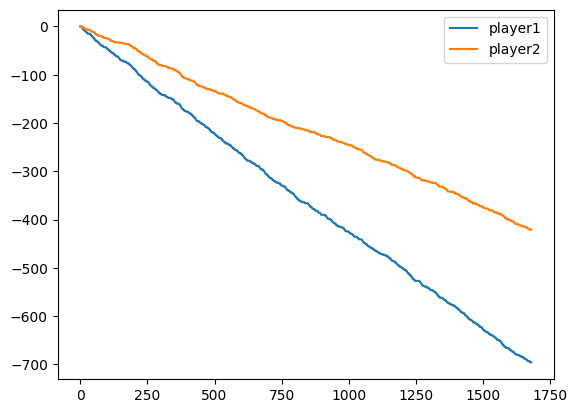

In [18]:
result = test_collector.collect(n_step=5000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [19]:
model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
if not hasattr(policy.policies[agents[0]], 'nolearn'):
    policy.policies[agents[0]].load_state_dict(torch.load(model_save_path1))
if not hasattr(policy.policies[agents[1]], 'nolearn'):
    policy.policies[agents[1]].load_state_dict(torch.load(model_save_path2))

death rate of player2: 0.248
ratio of death rate of player2 with respect to player1: 0.585


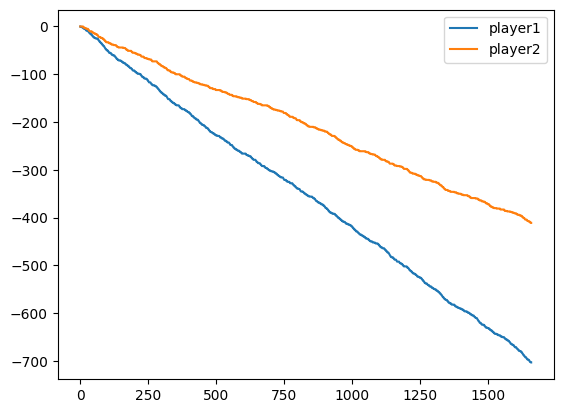

In [20]:
result = test_collector.collect(n_step=5000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [21]:
df = []
obs = []

for days_left in range(1, 3):
    for player1_life_points in range(4):
        for player2_life_points in range(4):
            for payoff in [0.2, 0.4]:
                for player1_action in range(0, 3):
                    for player2_action in range(0, 3):
                        curr_obs = [
                            days_left, 
                            player1_life_points, 
                            player2_life_points, 
                            payoff,
                            payoff,
                            player1_action, 
                            player2_action
                        ]
                        obs.append({
                            'agent_id': 'player2',
                            'obs': np.array([curr_obs], dtype='float32'),
                            'mask': [True, True, False]
                        })
                        df.append(curr_obs)

cols = [
    "days_left", 
    "player1_life_points", 
    "player2_life_points", 
    "player1_prob_payoff",
    "player2_prob_payoff",
    "player1_previous_action", 
    "player2_previous_action"
]
df = pd.DataFrame(df, columns=cols)

df["player2_predicted_action"] = policy.policies[agents[1]](Batch(obs=obs, info={})).act
df["player2_logit_wait"] = policy.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 0]
df["player2_logit_play"] = policy.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 1]

df["player1_previous_action"] = df["player1_previous_action"].map({0: "wait", 1: "play", 2: "none"})
df["player2_previous_action"] = df["player2_previous_action"].map({0: "wait", 1: "play", 2: "none"})
df["player2_predicted_action"] = df["player2_predicted_action"].map({0: "wait", 1: "play"})

df.to_csv("outcome_table.csv", index=False)

df.head()

,days_left,player1_life_points,player2_life_points,player1_prob_payoff,player2_prob_payoff,player1_previous_action,player2_previous_action,player2_predicted_action,player2_logit_wait,player2_logit_play
0,1,0,0,0.2,0.2,wait,wait,wait,-5.144244,-5.966360
1,1,0,0,0.2,0.2,wait,play,wait,-5.583667,-6.855631
2,1,0,0,0.2,0.2,wait,none,wait,-6.302387,-7.897372
3,1,0,0,0.2,0.2,play,wait,wait,-5.281620,-5.558662
4,1,0,0,0.2,0.2,play,play,wait,-5.213724,-5.900920


In [22]:
(df["player2_predicted_action"] == "play").mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.4947916666666667

In [23]:
df[df["player2_predicted_action"] == "play"].tail(15)

,days_left,player1_life_points,player2_life_points,player1_prob_payoff,player2_prob_payoff,player1_previous_action,player2_previous_action,player2_predicted_action,player2_logit_wait,player2_logit_play
554,2,3,2,0.4,0.4,play,none,play,-2.855327,-2.346450
555,2,3,2,0.4,0.4,none,wait,play,-3.717653,-2.277382
556,2,3,2,0.4,0.4,none,play,play,-3.089209,-2.065479
557,2,3,2,0.4,0.4,none,none,play,-2.741291,-1.909339
558,2,3,3,0.2,0.2,wait,wait,play,-2.697010,-2.652858
561,2,3,3,0.2,0.2,play,wait,play,-2.737608,-2.594360
564,2,3,3,0.2,0.2,none,wait,play,-2.883074,-2.512215
567,2,3,3,0.4,0.4,wait,wait,play,-2.422704,-1.831681
568,2,3,3,0.4,0.4,wait,play,play,-2.573875,-2.462578
570,2,3,3,0.4,0.4,play,wait,play,-2.459017,-1.761881
